In [198]:
import functools
import math
import numpy as np
from scipy import stats

import seaborn as sns
sns.set_context('notebook')
sns.set_style("white")

import matplotlib as plt
plt.rcParams['figure.figsize'] = (8,6)

from IPython.display import display

### Load Database

In [2]:
%run AH_DATABASE.ipynb


Usage: 
  db = DB(server)          --> initializes database
  db.get_df(item)          --> returns dataframe, prices divided by 100 so copper in decimal 
  db.get_name(item)        --> returns name of item  
  db.get_last_record(item) --> returns most recent record
  db.plot(item, y)         --> plots column over time



In [3]:
db = DB('earthfury-alliance', timerange=30)

### Calc Best Price

In [144]:

@functools.lru_cache(maxsize=1)
def daily_max(item):
    df = db.get_df(item)
    return df.groupby(by=df['scannedAt'].dt.date)['minBuyout'].max()


def pctile_days_buyable_at(item, price):
    df = db.get_df_hourly(item)
    df['rolling_min'] = df['minBuyout'].rolling(24).min()
    return stats.percentileofscore(df['rolling_min'].dropna(), price)/100

def pctile_days_sellable_at(item, price):
    df = db.get_df_hourly(item)
    df['rolling_max'] = df['minBuyout'].rolling(24).max()
    return 1-stats.percentileofscore(df['rolling_max'].dropna(), price)/100


def price_at_salerate(item, salerate):
    df = db.get_df_hourly(item)
    return df['minBuyout'].quantile(1-salerate)

def pctile_at_price(item, price):
    # inverse of quantile, seems to work with some slight numerical error
    df = db.get_df_hourly(item)
    return 1-stats.percentileofscore(df['minBuyout'], price)/100

def postcost_at_salerate(item, salerate):
    vp = db.get_vendorprice(item) # double check this value is working correctly using in game reference 
    return (1-salerate) / salerate * (.6*vp)

In [185]:
db.get_df_hourly(item)

,scannedAt,marketValue,minBuyout,quantity,minBuyoutPctile,rolling_min,rolling_max
0,2020-05-04 00:00:00+00:00,3.490,2.790,579.0,0.323478,NaN,NaN
1,2020-05-04 01:00:00+00:00,3.835,0.195,414.0,0.002609,NaN,NaN
2,2020-05-04 02:00:00+00:00,2.070,1.950,650.0,0.080000,NaN,NaN
3,2020-05-04 03:00:00+00:00,3.870,2.450,458.0,0.217391,NaN,NaN
4,2020-05-04 04:00:00+00:00,3.870,2.450,458.0,0.217391,NaN,NaN
...,...,...,...,...,...,...,...
706,2020-06-02 10:00:00+00:00,4.990,4.710,1858.0,0.811304,2.765,8.69
707,2020-06-02 11:00:00+00:00,4.930,4.000,1833.0,0.686087,2.765,8.69
708,2020-06-02 12:00:00+00:00,4.950,4.000,1763.0,0.686087,2.765,8.69
709,2020-06-02 13:00:00+00:00,4.950,4.000,1763.0,0.686087,2.765,8.69


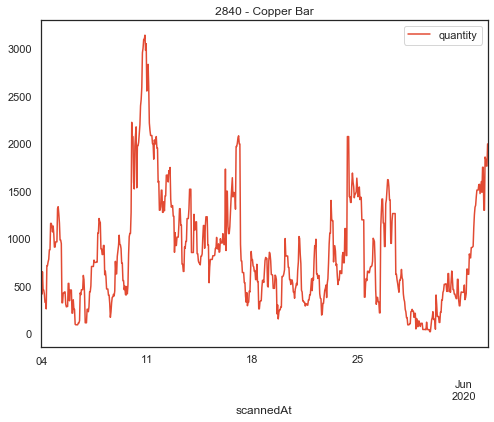

In [199]:
def show(item, x, y, style='-'):
    title = f'{item} - {db.get_name(item)}'
    df = db.get_df_hourly(item)
    df.plot(x=x, y=y, title=title, style=style)

item = 2840
show(2840, x='scannedAt', y='quantity')

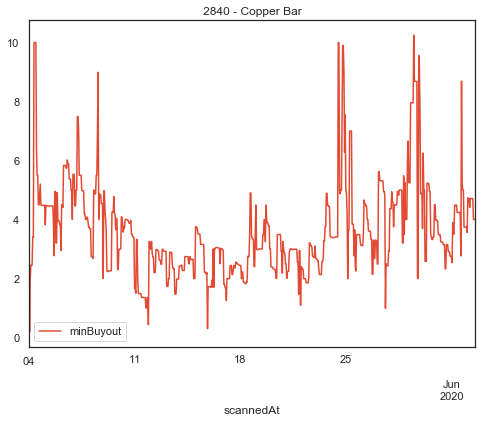

In [200]:
show(item, x='scannedAt', y='minBuyout')

In [183]:
# at some point every day the price drops below 5s
pctile_days_buyable_at(2840, 5)

1.0

In [184]:
# 38% of days the price jumps above 5s
pctile_days_sellable_at(2840, 5)

0.38372093023255816

In [186]:
# median price
price_at_salerate(2840, .5)

3.33

In [187]:
# sellable at median 75% of days
pctile_days_sellable_at(2840, 3.33)

0.7463662790697674

In [188]:
# buyable at median 93% of days
pctile_days_buyable_at(2840, 3.33)

0.9302325581395349

## Analysis

,item_id,name,pricePctile,salePrice,daysSellablePctile,daysBuyablePctile,postCost,value,timeValue,timeValueNorm
25,2840,Copper Bar,0.25,4.4725,0.604651,0.957849,0.039231,4.433269,2.567592,0.574084


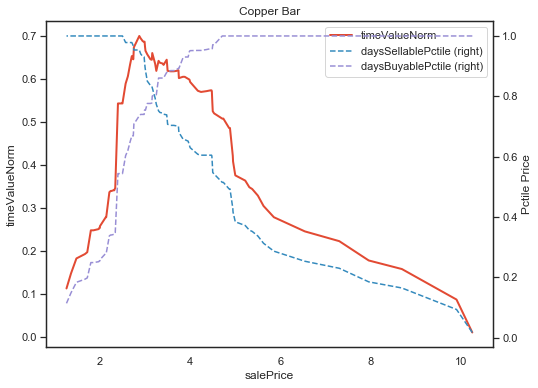

In [201]:
def analysis(item, show=False):
    # exclude low sale rates because
    # a) they're higher risk as capital is tied up longer
    # b) data in the low end can be swayed by unrealistice prices

    
    data = []
    medianPice = price_at_salerate(item, .5) # is this reliable, probably? Its the max price for the day, of the lowest day.
    for pricePctile in np.arange(0, 1, .01):
        d= {}
        d['item_id'] = item
        d['name'] = db.get_name(item)
        d['pricePctile'] = pricePctile
        d['salePrice']   = price_at_salerate(item, d['pricePctile'])    
        
        # consider time to sell
        d['daysSellablePctile'] = pctile_days_sellable_at(item, d['salePrice'])
        
        # consider time to buy at min 15% flip
        d['daysBuyablePctile'] = pctile_days_buyable_at(item, d['salePrice']*.85)

        # calc value based on posting cost
        d['postCost'] = postcost_at_salerate(item, d['daysSellablePctile']) # use days sellable as pctile due to 24hr post
        d['value']    = d['salePrice'] - d['postCost']
                
        # value per time
        d['timeValue']     = d['value'] * d['daysBuyablePctile'] * d['daysSellablePctile']
        d['timeValueNorm'] = d['timeValue'] / d['salePrice']
        data.append(d)
    
    df = pd.DataFrame(data)
    best = df.loc[df['timeValue'] == df['timeValue'].max()]
    if show:
        display(best)
        ax = df.plot(x='salePrice', y=['timeValueNorm'], title=db.get_name(item), linewidth=2)
        df.plot(x='salePrice', y=['daysSellablePctile', 'daysBuyablePctile'], style='--', secondary_y=True, ax=ax)
        ax.set_ylabel('timeValueNorm')
        ax.right_ax.set_ylabel('Pctile Price')
        
    return best.to_dict('r')[0]

row = analysis(item, show=True)

,item_id,name,pricePctile,salePrice,daysSellablePctile,daysBuyablePctile,postCost,value,timeValue,timeValueNorm
21,3820,Stranglekelp,0.21,26.3576,0.814224,0.988389,0.136898,26.220702,21.101622,0.80059


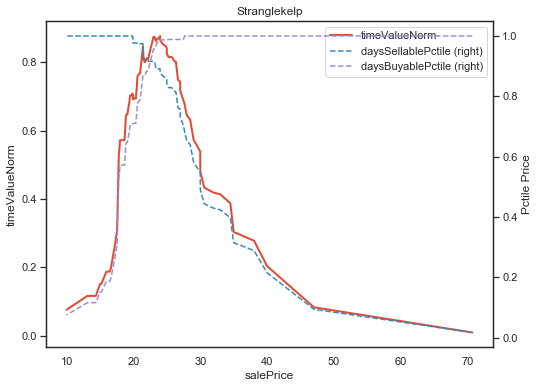

In [205]:
row = analysis(3820, show=True)

,item_id,name,pricePctile,salePrice,daysSellablePctile,daysBuyablePctile,postCost,value,timeValue,timeValueNorm
38,13444,Major Mana Potion,0.38,207.55,0.709724,0.677794,3.680982,203.869018,98.070531,0.472515


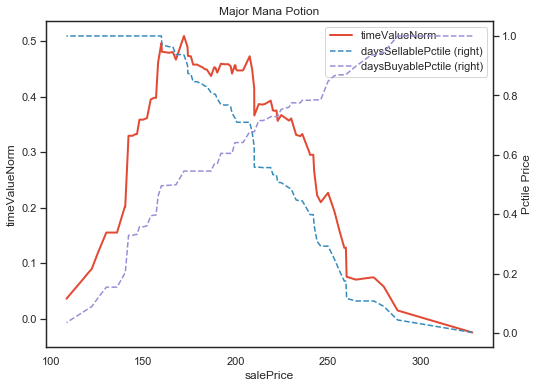

In [204]:
row = analysis(13444, show=True)

### Full Run

In [158]:
%run ITEMS.ipynb


loaded
  herbs       : 30 items
  cloth       : 12 items
  mining      : 27 items
  enchant     : 24 items
  skinning    : 11 items
  meat        : 27 items
  consumables : 44 items
  bags        : 38 items
  eng         : 53 items
  ALL         : 266 items



In [159]:
# a bunch of printing and error catching, to simply map(fn, list_of_items)
def run_analysis(list_of_items, fn):
    print(f'running for {len(list_of_items)} items')    
    results = []    
    for i, item in enumerate(list_of_items):       
        # catch no data errors with try/except
        try:
            results.append(fn(item))
        except: 
            print(f'! ERROR - {item}, {db.get_name(item)}')
        # print progress
        if i%10 ==0: print(f' ...{i} done')   
    print('COMPLETE')
    return pd.DataFrame(results).round(2)

df = run_analysis(ALL, analysis)

running for 266 items
 ...0 done
 ...10 done
 ...20 done
 ...30 done
 ...40 done
 ...50 done
 ...60 done
! ERROR - 17771, Elementium Bar
! ERROR - 3861, Blacksteel Bar
 ...70 done
 ...80 done
 ...90 done
! ERROR - 20725, Nexus Crystal
 ...100 done
 ...110 done
 ...120 done
! ERROR - 3730, Big Bear Meat
! ERROR - 5467, Kodo Meat
 ...130 done
 ...140 done
! ERROR - 20748, Brilliant Mana Oil
! ERROR - 20749, Brilliant Wizard Oil
! ERROR - 21546, Elixir of Greater Firepower
 ...150 done
! ERROR - 9264, Elixir of Shadow Power
 ...160 done
 ...170 done
! ERROR - 21023, Dirge's Kickin' Chimaerok Chops
 ...180 done
! ERROR - 21341, Felcloth Bag
 ...190 done
! ERROR - 4238, Linen Bag
! ERROR - 4497, Heavy Brown Bag
 ...200 done
 ...210 done
 ...220 done
! ERROR - 2836, Coarse Stone
 ...230 done
 ...240 done
! ERROR - 4399, Wooden Stock
! ERROR - 4400, Heavy Stock
 ...250 done
 ...260 done
COMPLETE


### Inspect Results

In [160]:
df['quantity'] = df['item_id'].apply(lambda x: db.get_last_record(x)['quantity'])
df.head()

,item_id,name,pricePctile,salePrice,daysSellablePctile,daysBuyablePctile,postCost,value,timeValue,timeValueNorm,quantity
0,8153,Wildvine,0.37,131.44,0.84,0.94,0.01,131.43,103.66,0.79,129
1,8836,Arthas' Tears,0.00,2502.13,0.02,1.00,30.85,2471.28,44.83,0.02,94
2,13468,Black Lotus,0.10,19595.00,0.25,0.74,18.18,19576.82,3617.57,0.18,29
3,13466,Plaguebloom,0.17,239.13,0.49,0.85,1.53,237.60,100.01,0.42,466
4,13465,Mountain Silversage,0.22,142.17,0.73,0.76,0.34,141.83,77.98,0.55,494


In [193]:
choice = df.query('quantity > 100 and salePrice > 5').sort_values(by='timeValueNorm').tail(50)
choice

,item_id,name,pricePctile,salePrice,daysSellablePctile,daysBuyablePctile,postCost,value,timeValue,timeValueNorm,quantity
161,13931,Nightfin Soup,0.08,62.00,0.33,0.95,0.14,61.86,19.59,0.32,821
156,3387,Limited Invulnerability Potion,0.21,375.83,0.46,0.70,0.21,375.62,120.14,0.32,168
129,13452,Elixir of the Mongoose,0.18,840.10,0.48,0.69,8.16,831.94,274.70,0.33,209
89,14344,Large Brilliant Shard,0.17,286.99,0.42,0.87,0.00,286.99,106.27,0.37,699
78,11174,Lesser Nether Essence,0.14,117.86,0.39,0.93,0.00,117.86,43.22,0.37,271
126,12404,Dense Sharpening Stone,0.21,59.28,0.47,0.81,0.50,58.77,22.37,0.38,499
157,5634,Free Action Potion,0.21,165.37,0.55,0.69,0.37,165.00,62.08,0.38,287
15,2450,Briarthorn,0.08,9.40,0.41,1.00,0.21,9.19,3.81,0.41,356
3,13466,Plaguebloom,0.17,239.13,0.49,0.85,1.53,237.60,100.01,0.42,466
69,11137,Vision Dust,0.11,14.83,0.42,1.00,0.00,14.83,6.29,0.42,295


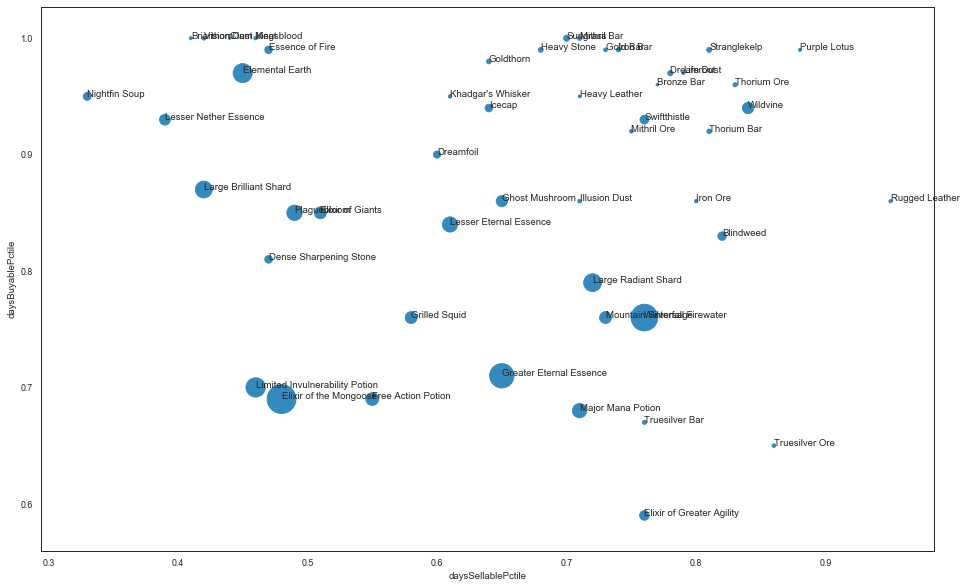

In [194]:
ax = choice.plot(kind='scatter', x='daysSellablePctile', y='daysBuyablePctile', s=choice['salePrice'], figsize=(16,10))

for _, r in choice.iterrows():
    ax.text(r['daysSellablePctile'], r['daysBuyablePctile'], r['name'])
    

### Export

In [189]:
%run EXPORT.ipynb

 
Usage:
  EXPORT(dataframe) --> expects df with specific columns
                          name         - required, string
                          item_id      - required, integer
                          buy_price    - required, integer in copper
                          min_price    - required, integer in copper 
                          normal_price - required, integer in copper
                          max_price    - required, integer in copper
                          restock      - optional, default 20
  example_export_input()  --> shows expected data schema
  example_export_output() --> shows output of example data



In [206]:
e = choice.copy()
# format for export (note, 100x to scale integer copper)
e['buy_price']    = 100 * e['salePrice'] * .85 
e['min_price']    = 100 * e['salePrice']
e['normal_price'] = 100 * e['salePrice'] * 1.1 # bit more profit when lowest post, but don't hurt saleRate
e['max_price']    = 100 * e['salePrice'] * 1.1 # bit more profit when lowest post, but don't hurt saleRate
e = e.astype({'buy_price':int, 'min_price':int, 'normal_price':int, 'max_price':int})

In [207]:
e['restock'] = 75

# stack_size=10 if item price is less than 1g, else stack_size=5
e['stack_size'] = e['salePrice'].apply(lambda x: 10 if x < 100 else 5)

In [208]:
EXPORT(e)

^1^T^Soperations^T^SMailing^T^S#Default^T^Srestock^b^SkeepQty^N0^SmaxQtyEnabled^b^Starget^S^SrestockSources^T^Sguild^b^Sbank^b^t^SmaxQty^N10^t^t^SAuctioning^T^SNightfin Soup^T^SaboveMax^SmaxPrice^SnormalPrice^S6820^Sduration^N3^SmatchStackSize^b^SkeepQuantity^N0^SpostCap^N20^SbidPercent^N1^SstackSizeIsCap^B^SmaxPrice^S6820^SignoreLowDuration^N0^SstackSize^N10^SkeepPosted^N0^Sundercut^S1c^SmaxExpires^N0^SpriceReset^SminPrice^ScancelRepostThreshold^S1g^ScancelRepost^B^ScancelUndercut^B^SminPrice^S6200^SkeepQtySources^T^t^Sblacklist^S^t^SLimited Invulnerability Potion^T^SaboveMax^SmaxPrice^SnormalPrice^S41341^Sduration^N3^SmatchStackSize^b^SkeepQuantity^N0^SpostCap^N20^SbidPercent^N1^SstackSizeIsCap^B^SmaxPrice^S41341^SignoreLowDuration^N0^SstackSize^N5^SkeepPosted^N0^Sundercut^S1c^SmaxExpires^N0^SpriceReset^SminPrice^ScancelRepostThreshold^S1g^ScancelRepost^B^ScancelUndercut^B^SminPrice^S37583^SkeepQtySources^T^t^Sblacklist^S^t^SElixir of the Mongoose^T^SaboveMax^SmaxPrice^SnormalPrice^S